In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHASEA_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-01-25 17:00:00+00:00 ETH      2433.860958   2492.540788   2433.283558   
                          LINK       15.400368     15.764800     15.369199   
                          MATIC       1.474711      1.552510      1.472450   
                          SOL        93.742075     97.936901     93.449850   
                          XRP         0.605174      0.614582      0.605174   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:30:00+00:00   
                          BTC     10466.256172 2019-07-20 01:30:00+00:00   
                          ETH       221.450416 2019-07-20 01:30:00+00:00   
                          XRP         0.319678 2019-07-20 01:30:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:30:00+00:00   
...                                        ...                       ...   
2022-01-25 17:00:00+00:00 ETH      2479.224107 2022-01-25 18:30:00+00:00   
                          LINK       15.644598 2022-01-25 18:30:00+00:00   
                          MATIC       1.537786 2022-01-25 18:30:00+00:00   
                          SOL        96.528443 2022-01-25 18:30:00+00:00   
                          XRP         0.611074 2022-01-25 18:30:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB          NaN  
                          BTC          NaN  
                          ETH          NaN  
                          XRP          NaN  
2019-07-20 01:00:00+00:00 BNB     0.012461  
...                                    ...  
2022-01-25 17:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[193043 rows x 6 columns]

In [3]:
class ExampleModel:
    def __init__(self):
        self._model = Ridge()
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script 
    
    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        return self._model.fit(df[features], df['ret'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()

        for i in [1, 2, 4, 8, 24]:
            df['feature_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)

        return df

return without cost statistics
mean 0.0026496058074426897
std 0.04458913570588071
sharpe 0.05942267697046306
max drawdown 0.6313134040719942
return with cost statistics
mean 0.0023223149200811205
std 0.044610531232710894
sharpe 0.05205754910128198
max drawdown 0.6329134040719943


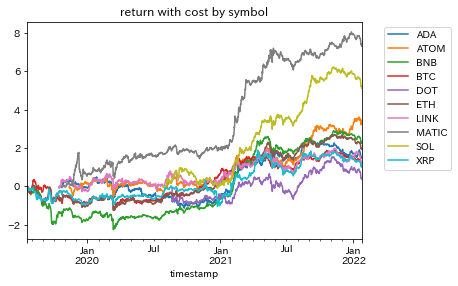

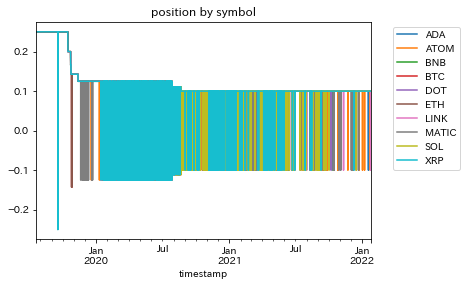

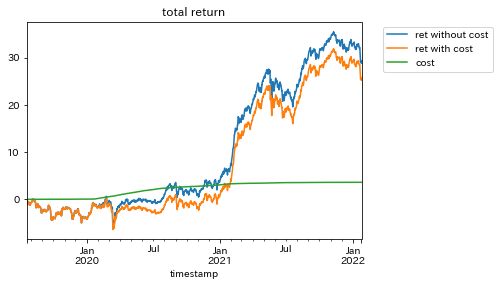

In [4]:
df = pd.read_pickle('/tmp/df.pkl')

model = ExampleModel()

# cv
calc_position_cv(model, df)

# result
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model.xz', 'wb') as f:
    f.write(data)

In [1]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)

timestamp                  symbol
2022-01-18 17:00:00+00:00  ADA       0.1
                           ATOM      0.1
                           BNB       0.1
                           BTC       0.1
                           DOT       0.1
                                    ... 
2022-01-25 17:00:00+00:00  ETH       0.1
                           LINK      0.1
                           MATIC     0.1
                           SOL       0.1
                           XRP       0.1
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
